1. Goal
2. The History of the Data
    - Introduction
    - Distributions
        - Numeric Variables
        - Categorical Variables
    - Statistics
    - What's the data telling us
3. Outliers Detection
    - Distributions and Statistics after Outlier Detection
4. Clustering
5. Remove redundant variables
6. Variable selection

# Goal

The aim of this notebook is to know in deep the current situation of the Irish Real State Market and figure out what are the most promissing variables in order to infer the price.

# Import Libraries and Set Options

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

import random

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')

# Load Data

In [1]:
sale = pd.read_csv('data_available/sale_cleaned.csv', sep=',', parse_dates=['entered_renewed', 'scraping_date'])
sale.shape

NameError: name 'pd' is not defined

In [4]:
sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7662 entries, 0 to 7661
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   daft_id          7662 non-null   int64         
 1   url              7662 non-null   object        
 2   name             7662 non-null   object        
 3   price            7662 non-null   float64       
 4   sale_type        7662 non-null   object        
 5   floor_area       7662 non-null   int64         
 6   psr              7646 non-null   float64       
 7   ber              7467 non-null   object        
 8   entered_renewed  7662 non-null   datetime64[ns]
 9   views            7662 non-null   float64       
 10  type_house       7175 non-null   object        
 11  type             7662 non-null   object        
 12  scraping_date    7662 non-null   datetime64[ns]
 13  description      7661 non-null   object        
 14  latitude         7662 non-null   float64

In [5]:
sale['plus_info'].sample()

3161    Semi-D
Name: plus_info, dtype: object

As we can see above, there is 18 columns in the dataset. Each one of them represent a variable related with the Irish Real State Market. Our target or variable response is `price`, whilst the other ones are predictors - variables that we can use to infer the price. Below you can see a table with each variable, its meaning and a brief explanation about whether we intuitively consider it is an important predictor or not.

|Variable|Meaning|Importance|Reason|Example|
|:---:|:---:|:---:|:---:|:---:|
|price|House market price|High|It is the target|180000.0|
|daft_id|Ad's id|In-between|It could help us to identify a particular house if we need to|16878701|
|url|Ad's url|In-between|We can visit the ad if we need to|[https://www.daft.ie/for-sale/apartment-5-the-willows-rivercourt-drogheda-co-louth/3608666](https://www.daft.ie/for-sale/apartment-5-the-willows-rivercourt-drogheda-co-louth/3608666)|
|name|Ad's name|Low|Its sctructure is too much heterogeneous and we have coordinates|5 The Willows, Rivercourt, Drogheda, Co. Louth|
|sale_type||Low|Almost all values are the same|For Sale by Private Treaty|
|floor_area|House's floor area|High|High potencial as a predictor|106|
|psr|Advertiser's identifier|Low|It is not an important attribute of the house|2239.0|
|ber|House's energetic efficiency|In-between|No sabe no contesta|B3|
|entered_renewed|Date of entry or renewal of the ad|Low|If an ad has been published for a long time or not is impossible to know because it can have been renewed|2021-11-24 00:00:00|
|views|Number of visits to the ad|In-between|No sabe no contesta|1381.0|
|type_house|Apartment or house|High|It looks like an important attribute|apartment|
|type|Buy or rent|Low|We are analyzing houses for sale, al values are the same|buy|
|scraping_date|Date when ads were scraped|Low|All values are the same|2021-11-25 00:00:00|
|description|Ad's description|In-between||...|
|latitude|House's latitude|High|Provides information about location|53.715574|
|longitude|House's longitude|High|Provides information about location|-6.371515|
|bedroom|Number of bedrooms|High|It looks like an important attribute of a house|2|
|bathroom|Number of bathrooms|High|It looks like an important attribute of a house|2|
|plus_info|More info in a word|Low|I don't know why but it doesn't look like something important|Detached|

# The Ireland's Real Estate Market

## Introduction

Agnadir algo de historia, como se distribuye y un par de mpaas.

## Current Situation of the Ireland's Real Estate Market

Este es buen punto para hacer un poco de feature engineering y crear nuevas variables a partir de las coordenadas. De este modo, seremos capaces de estudiar mejor como los datos se distribuyen geograficamente.

-> Feature_Engineering_Geospatial_Data

In [15]:
sale_data_post_geosp = pd.read_csv('data_available/sale_data_geosp_improved.csv', sep=',')
sale_data_post_geosp.shape

(7695, 32)

In [16]:
sale_data_post_geosp.isna().sum()

daft_id                 0
url                     0
name                    0
price                   0
sale_type               0
floor_area              0
entered_renewed         0
views                   0
type_house              0
type                    0
scraping_date           0
latitude                0
longitude               0
bedroom                 0
bathroom                0
country_code            0
country                 0
postcode             1302
state_district        371
county                701
municipality         6405
city                 5651
town                 6559
city_district         380
locality             7690
suburb               5914
road                 2003
house_number         6226
place                1375
code                 1375
admin1               1375
place_coordinates    1375
dtype: int64

### Geospatial Data Distributions and Statistics

### Ireland's Real Estate Market

#### Number of advertisements per city

In [17]:
sale_data_post_geosp.place.value_counts().head()

Cork city southside    244
Limerick               202
Galway                 199
Dublin 4               167
Dun Laoghaire          161
Name: place, dtype: int64

Vamos a hacer una nueva columna con los mismos datos pero en la que dublin no este diferenciada por postal istricts

In [18]:
print(sale_data_post_geosp.shape)
sale_data_post_geosp['cities'] = sale_data_post_geosp.place.copy()
print(sale_data_post_geosp.shape)

(7695, 32)
(7695, 33)


In [19]:
ix_to_change_dublin = sale_data_post_geosp.cities.dropna()[sale_data_post_geosp.cities.dropna().str.contains('Dublin')].index
ix_to_change_cork = sale_data_post_geosp.cities.dropna()[sale_data_post_geosp.cities.dropna().str.contains('Cork')].index
#ix_to_change

In [20]:
sale_data_post_geosp.loc[ix_to_change_dublin, 'cities'] = 'Dublin'
sale_data_post_geosp.loc[ix_to_change_cork, 'cities'] = 'Cork'

In [21]:
freq_cities = sale_data_post_geosp.cities.value_counts()
#freq_cities

In [22]:
freq_cities.values

array([1853,  353,  202,  199,  161,  118,  118,  113,  103,   96,   86,
         85,   80,   79,   72,   67,   67,   67,   66,   61,   61,   59,
         59,   55,   55,   51,   50,   50,   47,   46,   45,   45,   45,
         45,   44,   44,   42,   41,   41,   40,   40,   39,   38,   37,
         37,   37,   35,   35,   35,   34,   33,   33,   33,   32,   31,
         30,   30,   29,   27,   26,   26,   24,   23,   23,   20,   20,
         20,   20,   18,   18,   17,   17,   17,   17,   16,   15,   15,
         15,   15,   14,   14,   13,   13,   13,   13,   13,   12,   11,
         11,   11,   11,   10,    9,    9,    9,    8,    8,    7,    7,
          7,    7,    7,    6,    5,    4,    4,    4,    3,    3,    3,
          3,    3,    3,    2,    2])

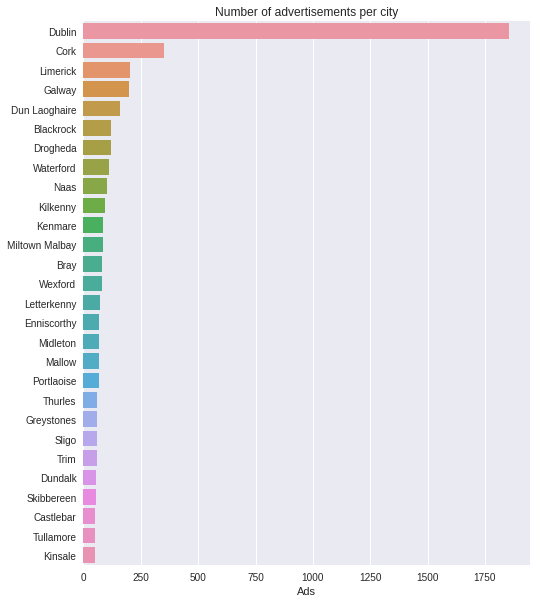

In [23]:
freq_cities = freq_cities[freq_cities >= 50].copy()

fig= plt.figure(figsize=(8,10))
ax = sns.barplot(x=freq_cities, y=freq_cities.index)
ax.set_title('Number of advertisements per city')
ax.set_xlabel('Ads');

In [24]:
freq_cities.index

Index(['Dublin', 'Cork', 'Limerick', 'Galway', 'Dun Laoghaire', 'Blackrock',
       'Drogheda', 'Waterford', 'Naas', 'Kilkenny', 'Kenmare',
       'Miltown Malbay', 'Bray', 'Wexford', 'Letterkenny', 'Enniscorthy',
       'Midleton', 'Mallow', 'Portlaoise', 'Thurles', 'Greystones', 'Sligo',
       'Trim', 'Dundalk', 'Skibbereen', 'Castlebar', 'Tullamore', 'Kinsale'],
      dtype='object')

#### Mean price per city

In [25]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [26]:
mean_price = sale_data_post_geosp.groupby(by='cities', axis=0)['price'].mean().sort_values(ascending=False)[freq_cities[freq_cities >= 100].index]
mean_price

Dublin           589919.86
Cork             366944.48
Limerick         317945.54
Galway           372713.57
Dun Laoghaire   1443631.06
Blackrock        788223.73
Drogheda         298207.63
Waterford        368039.82
Naas             600852.43
Name: price, dtype: float64

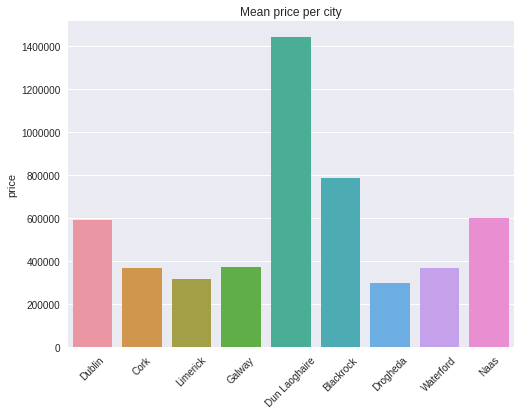

In [27]:
fig= plt.figure(figsize=(8,6))
ax = sns.barplot(x=mean_price.index, y=mean_price)
ax.set_title('Mean price per city')
ax.ticklabel_format(style='plain', axis='y')
ax.set_xticklabels(mean_price.index, rotation=45);
#ax.set_xticklabels(ax.get_xticks(), rotation = 45)
#ax.set_xlabel('Ads');

#### Mean price per m2 and city

In [28]:
sale_data_post_geosp['m2_price'] = sale_data_post_geosp.price / sale_data_post_geosp.floor_area

In [29]:
freq_cities[freq_cities >= 100].index

Index(['Dublin', 'Cork', 'Limerick', 'Galway', 'Dun Laoghaire', 'Blackrock',
       'Drogheda', 'Waterford', 'Naas'],
      dtype='object')

In [30]:
mean_m2_per_city = pd.pivot_table(data=sale_data_post_geosp, index='cities', values='m2_price', aggfunc='mean').sort_values(by='m2_price', ascending=False).loc[['Dublin', 'Cork', 'Limerick', 'Galway', 'Dun Laoghaire', 'Blackrock',
       'Drogheda', 'Waterford', 'Naas']]
mean_m2_per_city

,m2_price
cities,
Dublin,5109.97
Cork,3116.44
Limerick,2500.54
Galway,2981.29
Dun Laoghaire,6753.28
Blackrock,6103.43
Drogheda,2423.42
Waterford,2317.35
Naas,2948.43


In [31]:
mean_m2_per_city.m2_price.values

array([5109.97433331, 3116.43619173, 2500.54415536, 2981.29466443,
       6753.27937601, 6103.43248309, 2423.41991205, 2317.35264392,
       2948.42864058])

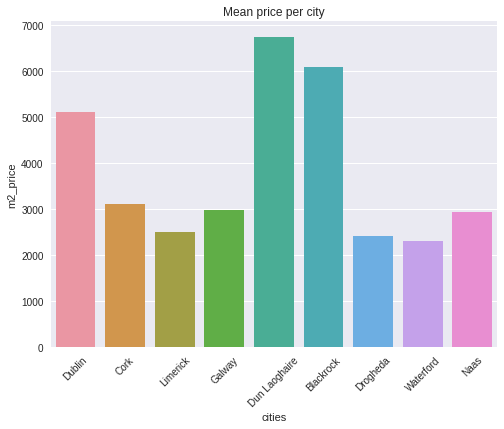

In [32]:
fig= plt.figure(figsize=(8,6))
ax = sns.barplot(x=mean_m2_per_city.index, y=mean_m2_per_city.m2_price)
ax.set_title('Mean price per city')
ax.ticklabel_format(style='plain', axis='y')
ax.set_xticklabels(mean_price.index, rotation=45);

#### Mean price of m2 per city by type_house

In [33]:
mean_m2_per_city_by_type_house = pd.pivot_table(data=sale_data_post_geosp, index=['cities', 'type_house'], values='m2_price', aggfunc='mean').sort_values(by='m2_price', ascending=False).loc[['Dublin', 'Cork', 'Limerick', 'Galway', 'Dun Laoghaire', 'Blackrock',
       'Drogheda', 'Waterford', 'Naas']]
mean_m2_per_city_by_type_house

m2_price
cities        type_house          
Dublin        apartment    5193.76
              house        5070.15
Cork          apartment    3531.77
              house        3047.90
Limerick      apartment    2616.99
              house        2469.05
Galway        apartment    3501.71
              house        2846.25
Dun Laoghaire house        6808.25
              apartment    6555.38
Blackrock     house        6260.51
              apartment    5874.36
Drogheda      house        2455.41
              apartment    2185.78
Waterford     house        2342.59
              apartment    1935.24
Naas          apartment    3100.06
              house        2907.25

In [34]:
mean_m2_per_city_by_type_house.unstack()

m2_price        
type_house    apartment   house
cities                         
Dublin          5193.76 5070.15
Cork            3531.77 3047.90
Limerick        2616.99 2469.05
Galway          3501.71 2846.25
Dun Laoghaire   6555.38 6808.25
Blackrock       5874.36 6260.51
Drogheda        2185.78 2455.41
Waterford       1935.24 2342.59
Naas            3100.06 2907.25

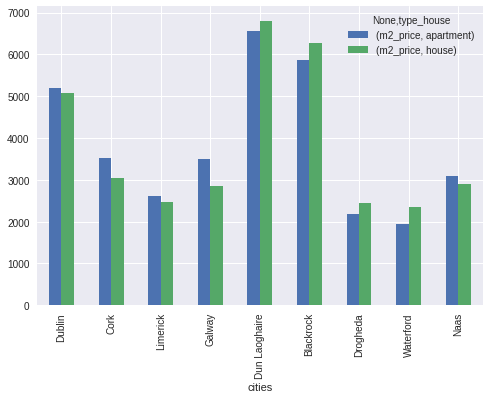

In [35]:
mean_m2_per_city_by_type_house.unstack().plot(kind='bar', stacked=False);

### Dublin's Real Estate Market

In [36]:
sale_data_post_geosp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7695 entries, 0 to 7694
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   daft_id            7695 non-null   int64  
 1   url                7695 non-null   object 
 2   name               7695 non-null   object 
 3   price              7695 non-null   float64
 4   sale_type          7695 non-null   object 
 5   floor_area         7695 non-null   int64  
 6   entered_renewed    7695 non-null   object 
 7   views              7695 non-null   float64
 8   type_house         7695 non-null   object 
 9   type               7695 non-null   object 
 10  scraping_date      7695 non-null   object 
 11  latitude           7695 non-null   float64
 12  longitude          7695 non-null   float64
 13  bedroom            7695 non-null   int64  
 14  bathroom           7695 non-null   int64  
 15  country_code       7695 non-null   object 
 16  country            7695 

In [37]:
sale_data_post_geosp.dropna(subset=['place']).loc[sale_data_post_geosp.place.dropna().str.contains('Dublin'), 'place'].value_counts()

Dublin 4     167
Dublin 8     156
Dublin 18    152
Dublin 6     117
Dublin 9     107
Dublin 1     107
Dublin 15    105
Dublin 13    104
Dublin 24    102
Dublin 14     93
Dublin 7      93
Dublin 12     89
Dublin 3      81
Dublin 16     78
Dublin 22     74
Dublin 11     59
Dublin 2      47
Dublin 20     31
Dublin 6W     30
Dublin 17     29
Dublin 5      19
Dublin 10     13
Name: place, dtype: int64

In [38]:
sale_data_dublin = sale_data_post_geosp.dropna(subset=['place']).loc[sale_data_post_geosp.place.dropna().str.contains('Dublin')]
sale_data_dublin.shape

(1853, 34)

In [39]:
mean_price_dublin_by_postal_districts_w_count = pd.pivot_table(data=sale_data_dublin, index='place', values='price', aggfunc=['mean','count']).sort_values(by=[('mean','price')], ascending=False)
mean_price_dublin_by_postal_districts_w_count

,mean,count
,price,price
place,,
Dublin 6,1119213.25,117
Dublin 4,1007760.48,167
Dublin 18,828500.99,152
Dublin 13,738584.62,104
Dublin 2,698191.49,47
Dublin 14,661257.53,93
Dublin 6W,627933.33,30
Dublin 3,590962.35,81


In [40]:
mean_price_dublin_by_postal_districts = pd.pivot_table(data=sale_data_dublin, index='place', values='price', aggfunc='mean').sort_values(by='price', ascending=False)
mean_price_dublin_by_postal_districts

,price
place,
Dublin 6,1119213.25
Dublin 4,1007760.48
Dublin 18,828500.99
Dublin 13,738584.62
Dublin 2,698191.49
Dublin 14,661257.53
Dublin 6W,627933.33
Dublin 3,590962.35
Dublin 20,545641.94


In [41]:
type(mean_price_dublin_by_postal_districts.mean)

method

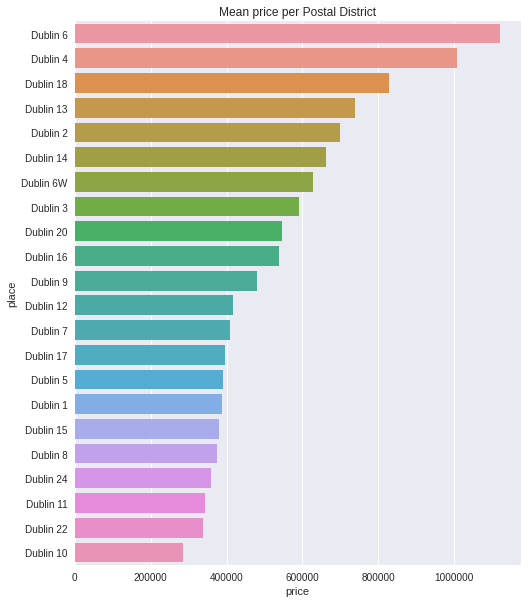

In [42]:
data = mean_price_dublin_by_postal_districts

fig= plt.figure(figsize=(8,10))
ax = sns.barplot(x=data.price, y=data.index, data=data)
ax.set_title('Mean price per Postal District');
ax.ticklabel_format(style='plain', axis='x');
#ax.set_xticklabels(mean_price.index, rotation=45);

In [43]:
sale_data_dublin.sample()

,daft_id,url,name,price,sale_type,floor_area,entered_renewed,views,type_house,type,scraping_date,latitude,longitude,bedroom,bathroom,country_code,country,postcode,state_district,county,municipality,city,town,city_district,locality,suburb,road,house_number,place,code,admin1,place_coordinates,cities,m2_price
1336,16495908,https://www.daft.ie/for-sale/terraced-house-14...,"14 Aideen Place, Terenure, Dublin 6W",650000.00,For Sale by Private Treaty,119,2021-10-18,2473.00,house,buy,2021-10-19,53.32,-6.29,3,3,ie,Éire / Ireland,D6W F729,Leinster,County Dublin,NaN,Dublin,NaN,Terenure A ED,NaN,Kimmage (pt. Rathfarnham C.P.),Aideen Place,NaN,Dublin 6W,D6W,Leinster,53.309/-6.301,Dublin,5462.18


In [44]:
mean_m2_price_dublin_by_postal_districts = pd.pivot_table(data=sale_data_dublin, index='place', values='m2_price', aggfunc='mean').sort_values(by='m2_price', ascending=False)
mean_m2_price_dublin_by_postal_districts

,m2_price
place,
Dublin 4,7325.21
Dublin 2,6953.52
Dublin 6,6650.10
Dublin 10,6136.93
Dublin 6W,5829.90
Dublin 14,5598.55
Dublin 18,5317.75
Dublin 8,5236.47
Dublin 3,5163.53


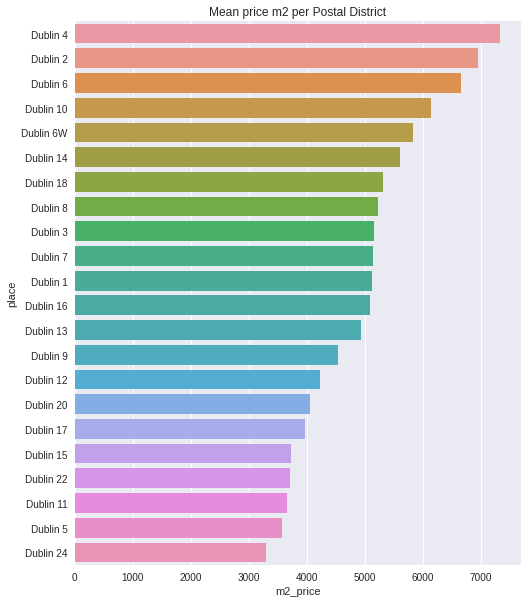

In [45]:
data = mean_m2_price_dublin_by_postal_districts

fig= plt.figure(figsize=(8,10))
ax = sns.barplot(x=data.m2_price, y=data.index, data=data)
ax.set_title('Mean price m2 per Postal District');
ax.ticklabel_format(style='plain', axis='x');
#ax.set_xticklabels(mean_price.index, rotation=45);

In [46]:
mean_m2_price_dublin_by_postal_district_and_type_house = pd.pivot_table(data=sale_data_dublin, index=['place', 'type_house'], values='m2_price', aggfunc='mean')#.sort_values(by='m2_price', ascending=False)#.loc[['Dublin', 'Cork', 'Limerick', 'Galway', 'Dun Laoghaire', 'Blackrock',
       #'Drogheda', 'Waterford', 'Naas']]
mean_m2_price_dublin_by_postal_district_and_type_house

m2_price
place     type_house          
Dublin 1  apartment    5212.44
          house        4950.01
Dublin 10 house        6136.93
Dublin 11 apartment    3529.90
          house        3680.85
Dublin 12 apartment    3358.09
          house        4297.71
Dublin 13 apartment    4658.10
          house        5053.93
Dublin 14 apartment    5939.41
          house        5505.17
Dublin 15 apartment    3959.14
          house        3611.74
Dublin 16 apartment    5475.20
          house        4909.60
Dublin 17 apartment    4122.47
          house        3944.91
Dublin 18 apartment    4890.49
          house        5604.15
Dublin 2  apartment    7122.39
          house        6461.01
Dublin 20 apartment    3790.67
          house        4100.36
Dublin 22 apartment    3192.89
          house        3844.12
Dublin 24 apartment    3441.77
          house        3221.91
Dublin 3  apartment    5471.05
          house        5062.70
Dublin 4  apartment    6797.04
          house        7653.40
Dublin 5  apartment    3481.01
          house        3572.97
Dublin 6  apartment    6299.69
          house        6755.23
Dublin 6W apartment    6027.72
          house        5790.34
Dublin 7  apartment    5046.21
          house        5182.45
Dublin 8  apartment    5283.35
          house        5199.29
Dublin 9  apartment    4403.90
          house        4577.60

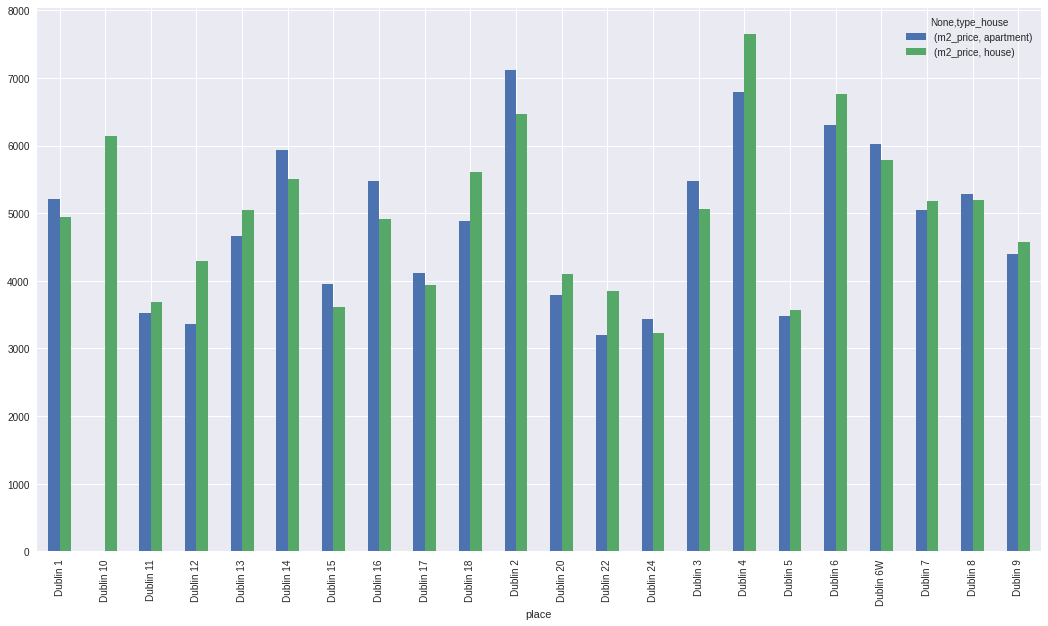

In [47]:
mean_m2_price_dublin_by_postal_district_and_type_house.unstack().plot(kind='bar', stacked=False, figsize=(18,10));

In [48]:
sale_data_dublin.sample()

,daft_id,url,name,price,sale_type,floor_area,entered_renewed,views,type_house,type,scraping_date,latitude,longitude,bedroom,bathroom,country_code,country,postcode,state_district,county,municipality,city,town,city_district,locality,suburb,road,house_number,place,code,admin1,place_coordinates,cities,m2_price
4676,16093502,https://www.daft.ie/for-sale/apartment-13-st-l...,"13 St. Lawrence Quay Harbour Road Howth, Howth...",475000.00,For Sale by Private Treaty,112,2021-10-19,7337.00,apartment,buy,2021-10-19,53.39,-6.07,3,2,ie,Éire / Ireland,D13 X296,Leinster,County Dublin,Fingal,NaN,Howth,Howth ED,NaN,NaN,Harbour Road,NaN,Dublin 13,D13,Leinster,53.395/-6.149,Dublin,4241.07


In [49]:
mean_floor_area_dublin_by_postal_district = pd.pivot_table(data=sale_data_dublin, index='place', values='floor_area', aggfunc='mean').sort_values(by='floor_area', ascending=False)#.loc[['Dublin', 'Cork', 'Limerick', 'Galway', 'Dun Laoghaire', 'Blackrock',
       #'Drogheda', 'Waterford', 'Naas']]
mean_floor_area_dublin_by_postal_district

,floor_area
place,
Dublin 20,191.68
Dublin 6,162.51
Dublin 5,158.58
Dublin 18,151.67
Dublin 13,141.98
Dublin 4,131.60
Dublin 14,121.26
Dublin 24,119.97
Dublin 3,118.94


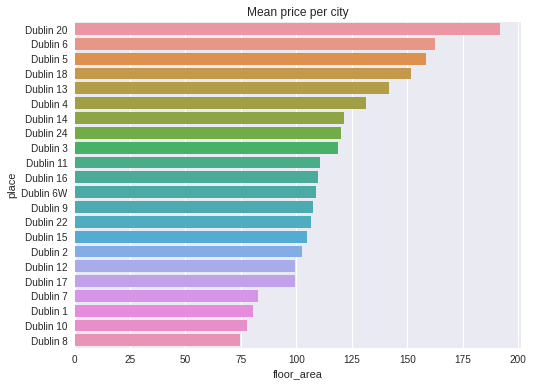

In [50]:
fig= plt.figure(figsize=(8,6))
ax = sns.barplot(x=mean_floor_area_dublin_by_postal_district.floor_area, y=mean_floor_area_dublin_by_postal_district.index)
ax.set_title('Mean price per city')
ax.ticklabel_format(style='plain', axis='x')
#ax.set_xticklabels(mean_price.index, rotation=45);

### Cork's Real Estate Market

In [51]:
sale_data_post_geosp.dropna(subset=['place']).loc[sale_data_post_geosp.place.dropna().str.contains('Cork'), 'place'].value_counts()

Cork city southside    244
Cork city northside    109
Name: place, dtype: int64

In [52]:
sale_data_post_geosp.dropna(subset=['city']).loc[sale_data_post_geosp.city.dropna().str.contains('Cork'), 'place'].value_counts()

Cork city southside    217
Cork city northside     91
Ballincollig            21
Glanmire                 3
Name: place, dtype: int64

In [53]:
sale_data_cork = sale_data_post_geosp.dropna(subset=['place']).loc[sale_data_post_geosp.place.dropna().str.contains('Cork')]
sale_data_cork.shape

(353, 34)

In [54]:
mean_price_cork_by_side = pd.pivot_table(data=sale_data_cork, index='place', values='price', aggfunc='mean').sort_values(by='price', ascending=False)
mean_price_cork_by_side

,price
place,
Cork city southside,386577.87
Cork city northside,322994.50


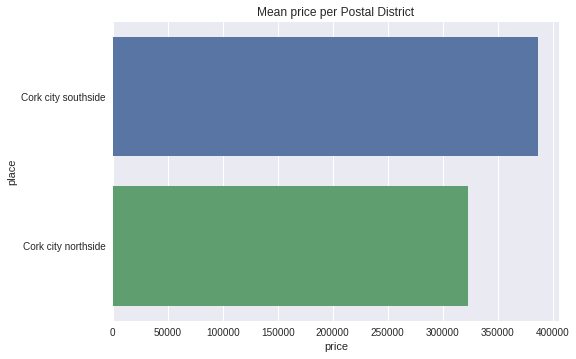

In [55]:
data = mean_price_cork_by_side

#fig= plt.figure(figsize=(8,10))
ax = sns.barplot(x=data.price, y=data.index, data=data)
ax.set_title('Mean price per Postal District');
ax.ticklabel_format(style='plain', axis='x');
#ax.set_xticklabels(mean_price.index, rotation=45);

In [56]:
mean_m2_price_cork_by_side_and_type_house = pd.pivot_table(data=sale_data_cork, index=['place', 'type_house'], values='m2_price', aggfunc='mean')#.sort_values(by='m2_price', ascending=False)#.loc[['Dublin', 'Cork', 'Limerick', 'Galway', 'Dun Laoghaire', 'Blackrock',
       #'Drogheda', 'Waterford', 'Naas']]
mean_m2_price_cork_by_side_and_type_house

m2_price
place               type_house          
Cork city northside apartment    3155.09
                    house        2828.30
Cork city southside apartment    3650.72
                    house        3151.30

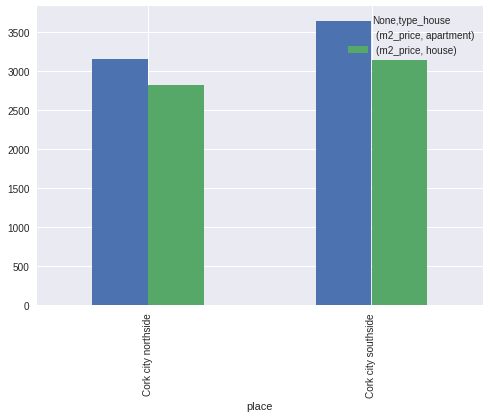

In [57]:
mean_m2_price_cork_by_side_and_type_house.unstack().plot(kind='bar', stacked=False);

### Clustering the Data

# Outliers Detection

#### Percentile based method

In [58]:
def pct_method(data, level):
    # Upper and lower limits by percentiles
    upper = np.percentile(data, 100 - level)
    lower = np.percentile(data, level)
    # Returning the upper and lower limits
    return [lower, upper]

#### Interquartile range method

In [59]:
def iqr_method(data):
    # Calculating the IQR
    perc_75 = np.percentile(data, 75)
    perc_25 = np.percentile(data, 25)
    iqr_range = perc_75 - perc_25
    # Obtaining the lower and upper bound
    iqr_upper = perc_75 + 1.5 * iqr_range
    iqr_lower = perc_25 - 1.5 * iqr_range
    # Returning the upper and lower limits
    return [iqr_lower, iqr_upper]

In [60]:
# This approach only works if the data is approximately Gaussian
def std_method(data):
    # Creating three standard deviations away boundaries
    std = np.std(data)
    upper_3std = np.mean(data) + 3 * std
    lower_3std = np.mean(data) - 3 * std
    # Returning the upper and lower limits
    return [lower_3std, upper_3std]

In [61]:
def outlier_bool(df, feature, level=1, continuous=False, log=False):
    
    data = df[feature]
    
    
    
    # Taking logs is specified
    if log is True:
        data = np.log(data + 1)
    # Obtaining the ranges
    pct_range = pct_method(data, level)
    iqr_range = iqr_method(data)
    std_range = std_method(data)
    
    if continuous is False:
        # Setting the lower limit fixed for discrete variables
        low_limit = np.min(data)
        high_limit = np.max([pct_range[1],
                             iqr_range[1],
                             std_range[1]])
        
    elif continuous is True:
        if feature is 'floor_area':
            #print('si')
            low_limit = pct_range[0]
        else:
            #print('no')
            low_limit = np.min([pct_range[0],
                                iqr_range[0],
                                std_range[0]])
        high_limit = np.max([pct_range[1],
                             iqr_range[1],
                             std_range[1]])
        
    print(f'Limits: {[low_limit, high_limit]}')
# Restrict the data with the minimum and maximum
    outlier = data.between(low_limit, high_limit)
    print(f'No outliers: {outlier.sum()}')
    print(f'Outliers: {(outlier==False).sum()}\n')
    
    
# Return boolean
    return outlier

In [62]:
def drop_outliers(df, feature, level=1, continuous=False, log=False, inplace=False):
    print(f'Range before: {[df[feature].min(), df[feature].max()]}\n')
    outlier_boolean = outlier_bool(df=df, feature=feature, level=1, continuous=continuous, log=False)
    rows_before = df.shape[0]
    df = df[outlier_boolean]
    rows_after = df.shape[0]
    print(f'Range after: {[df[feature].min(), df[feature].max()]}')
    print(f'Outliers dropped: {rows_before - rows_after}')
    return df

#### Dropping `price` Outliers

In [63]:
sale_data = sale_data_post_geosp.copy()

In [64]:
sd_out_price = drop_outliers(sale_data, 'price', continuous=True)
sd_out_price.shape

Range before: [25000.0, 10000000.0]

Limits: [-1237259.320268431, 2650000.0]
No outliers: 7621
Outliers: 74

Range after: [25000.0, 2650000.0]
Outliers dropped: 74


(7621, 34)

In [65]:
pct_range = pct_method(sale_data.price, level=1)
iqr_range = iqr_method(sale_data.price)
std_range = std_method(sale_data.price)

print(pct_range)
print(iqr_range)
print(std_range)

[80000.0, 2650000.0]
[-162500.0, 857500.0]
[-1237259.320268431, 2119507.0003204127]


In [66]:
sale_data.price.sort_values().head() # Los quito?

1054   25000.00
7306   32000.00
6953   40000.00
7671   40000.00
7066   45000.00
Name: price, dtype: float64

In [67]:
sd_out_price.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693, 7694],
           dtype='int64', length=7621)

#### Dropping `floor_area` Outliers

In [68]:
sd_out_farea = drop_outliers(sale_data, 'floor_area', continuous=True)
sd_out_farea.shape

Range before: [1, 10279]

Limits: [38.0, 712.8395035046221]
No outliers: 7575
Outliers: 120

Range after: [38, 710]
Outliers dropped: 120


(7575, 34)

Aqui no funciona muy bien porque permite valores pequegnos sin sentido para una casa. En este caso usaremos el limite inferior del percentile method, que es el mas restrictivo. 

In [69]:
pct_range = pct_method(sale_data.floor_area, level=1)
iqr_range = iqr_method(sale_data.floor_area)
std_range = std_method(sale_data.floor_area)

print(pct_range)
print(iqr_range)
print(std_range)

[38.0, 624.5399999999954]
[-47.5, 300.5]
[-414.45587777362795, 712.8395035046221]


In [70]:
sale_data.floor_area.sort_values().head()

6243    1
4072    1
7229    1
7236    1
7096    1
Name: floor_area, dtype: int64

In [71]:
sd_out_farea.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693, 7694],
           dtype='int64', length=7575)

#### Dropping `views` Outliers

In [72]:
sd_out_views = drop_outliers(sale_data, 'views', continuous=True)
sd_out_views.shape

Range before: [0.0, 136456.0]

Limits: [-15968.402634048929, 36608.39999999998]
No outliers: 7618
Outliers: 77

Range after: [0.0, 36606.0]
Outliers dropped: 77


(7618, 34)

In [73]:
pct_range = pct_method(sale_data.views, level=1)
iqr_range = iqr_method(sale_data.views)
std_range = std_method(sale_data.views)

print(pct_range)    ####
print(iqr_range)
print(std_range)

[413.88, 36608.39999999998]
[-6069.25, 16852.75]
[-15968.402634048929, 29595.71595438681]


In [74]:
sale_data['views'].sort_values().head()

1652   0.00
5160   0.00
7048   0.00
5984   0.00
3857   0.00
Name: views, dtype: float64

In [75]:
sd_out_views.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7692, 7693],
           dtype='int64', length=7618)

#### Dropping `bedroom` Outliers

In [76]:
sd_out_bedroom = drop_outliers(sale_data, 'bedroom', continuous=True)
sd_out_bedroom.shape

Range before: [1, 43]

Limits: [-1.1126768456067389, 8.0]
No outliers: 7644
Outliers: 51

Range after: [1, 8]
Outliers dropped: 51


(7644, 34)

In [77]:
pct_range = pct_method(sale_data.bedroom, level=1)
iqr_range = iqr_method(sale_data.bedroom)
std_range = std_method(sale_data.bedroom)

print(pct_range)    ####
print(iqr_range)
print(std_range)

[1.0, 8.0]
[1.5, 5.5]
[-1.1126768456067389, 7.952183018446245]


In [78]:
sale_data['bedroom'].sort_values().head()

1212    1
930     1
2444    1
2446    1
370     1
Name: bedroom, dtype: int64

In [79]:
sd_out_bedroom.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7693, 7694],
           dtype='int64', length=7644)

#### Dropping `bathroom` Outliers

In [80]:
sd_out_bathroom = drop_outliers(sale_data, 'bathroom', continuous=True)
sd_out_bathroom.shape

Range before: [1, 47]

Limits: [-2.0776398208827422, 7.0]
No outliers: 7624
Outliers: 71

Range after: [1, 7]
Outliers dropped: 71


(7624, 34)

In [81]:
pct_range = pct_method(sale_data.bathroom, level=1)
iqr_range = iqr_method(sale_data.bathroom)
std_range = std_method(sale_data.bathroom)

print(pct_range)    ####
print(iqr_range)
print(std_range)

[1.0, 7.0]
[-2.0, 6.0]
[-2.0776398208827422, 6.77809466168846]


In [82]:
sale_data['bathroom'].sort_values().head()

1773    1
5054    1
2131    1
5047    1
2140    1
Name: bathroom, dtype: int64

Con todo lo de arriba puedo hacer un for loop

In [83]:
sd_out_bathroom.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            7684, 7685, 7686, 7687, 7688, 7689, 7690, 7691, 7693, 7694],
           dtype='int64', length=7624)

In [84]:
sale_data.shape

(7695, 34)

In [85]:
index_list = [sd_out_price.index, sd_out_farea.index, sd_out_views.index, sd_out_bedroom.index, sd_out_bathroom.index]

def common_ix(index_list):
    data_ix = []
    for i, elem in enumerate(index_list):
        if i == 0:
            initial_ix = elem
            for ix in initial_ix:
                if ix in index_list[i+1]:
                    data_ix.append(ix)
            print(len(data_ix))
    
        elif i < 4:
            for ix in data_ix:
                if ix not in index_list[i+1]:
                    data_ix.remove(ix)
            print(len(data_ix))
    return data_ix

In [86]:
data_ix = common_ix(index_list)

7514
7459
7419
7387


In [87]:
print(sale_data.shape)
sale_data_out = sale_data.iloc[data_ix]
print(sale_data_out.shape)

(7695, 34)
(7387, 34)


In [88]:
def drop_all_outliers(df, index_list):
    data_ix = common_ix(index_list)
    print(df.shape)
    sale_data_out = df.iloc[data_ix]
    print(sale_data_out.shape)
    return sale_data_out

In [89]:
sale_data_out = drop_all_outliers(df=sale_data, index_list=index_list)

7514
7459
7419
7387
(7695, 34)
(7387, 34)


In [90]:
sale_data_out.drop(columns=['daft_id']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,7387.00,393253.02,305115.91,25000.00,220000.00,305000.00,460000.00,2650000.00
floor_area,7387.00,135.21,79.03,38.00,83.00,111.00,164.00,710.00
views,7387.00,6213.88,5592.82,0.00,2476.00,4440.00,7967.00,37861.00
latitude,7387.00,53.08,0.72,51.46,52.63,53.28,53.40,55.32
longitude,7387.00,-7.43,1.18,-10.46,-8.49,-7.11,-6.28,-6.03
bedroom,7387.00,3.32,1.17,1.00,3.00,3.00,4.00,8.00
bathroom,7387.00,2.25,1.14,1.00,1.00,2.00,3.00,7.00
m2_price,7387.00,3147.83,1748.66,78.57,1865.67,2643.68,4063.57,13846.15


# Distributions

### Numeric Variables

In [6]:
# It hs no sense calculate statistics for `daft_ie` and `psr` columns
sale.drop(columns=['daft_id', 'psr']).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
price,7662.0,434951.206604,541330.762791,32000.000000,220000.000000,310000.000000,470000.000000,1.000000e+07
floor_area,7662.0,148.320021,197.573868,1.000000,83.000000,112.000000,167.000000,1.027900e+04
views,7662.0,7142.133647,7586.564519,0.000000,2799.000000,5085.000000,8670.750000,1.250300e+05
latitude,7662.0,53.080876,0.728831,51.460139,52.608102,53.285901,53.406217,5.536892e+01
longitude,7662.0,-7.428969,1.185824,-10.443240,-8.488956,-7.114530,-6.280602,-6.027847e+00
bedroom,7662.0,3.396241,1.516003,1.000000,3.000000,3.000000,4.000000,4.300000e+01
bathroom,7662.0,2.302924,1.457751,1.000000,1.000000,2.000000,3.000000,4.700000e+01


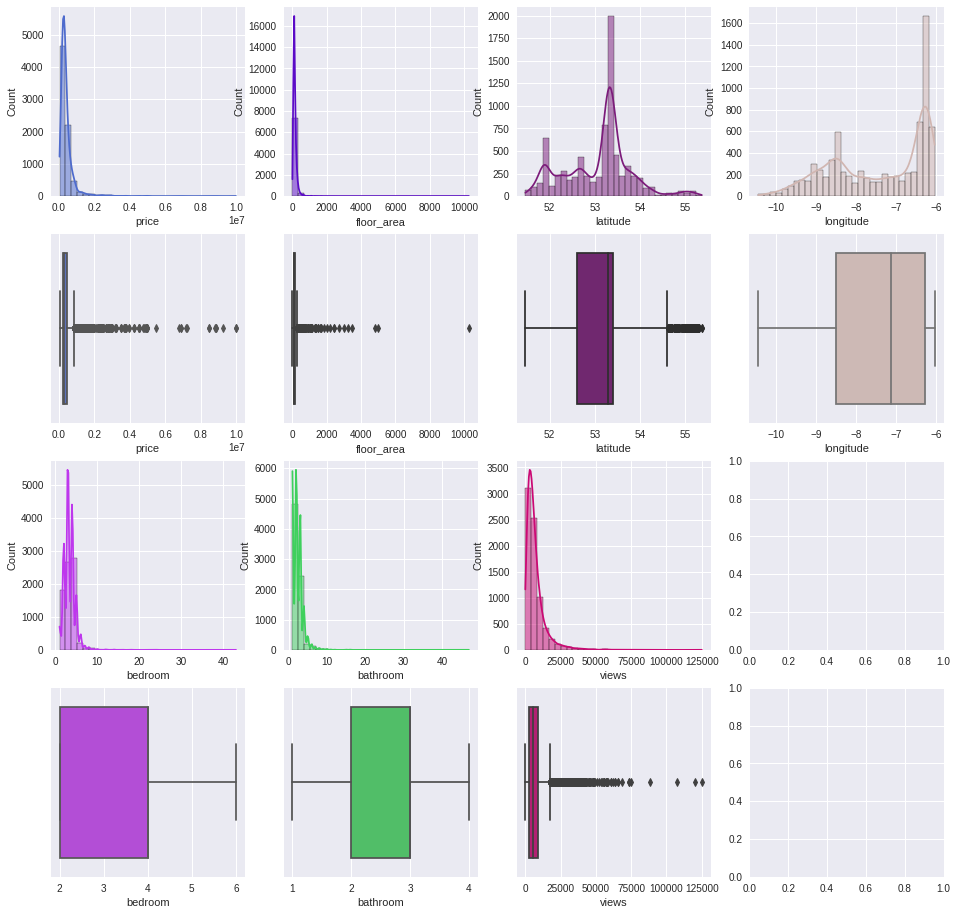

In [26]:
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

features = ['price', 'floor_area', 'latitude', 'longitude', 'bedroom', 'bathroom', 'views']
# Generates 7 random colors
random.seed(7)
colors = ["#" + ''.join([random.choice('ABCDEF0123456789') for i in range(6)]) for j in range(7)]

# The below variables will be useful to provide the right axis
count = 0
row_hist = 0
row_boxp = 1
column = 0

for feature, color in zip(features, colors):
    if count >= 4:
        row_hist = 2
        row_boxp = 3
    
    sns.histplot(data=sale[feature], kde=True, bins=30, color=color, 
                 ax=axs[row_hist, column]) 
    sns.boxplot(data=sale[feature], x=sale[feature], color=color, 
                ax=axs[row_boxp, column])
    
    if column == 3:
        column = -1
        
    count += 1
    column += 1

Meter aqui outlier detection para numericas

### Categorical Variables

#### Type House

In [9]:
sale_data.type_house.value_counts()

house        6479
apartment    1216
Name: type_house, dtype: int64

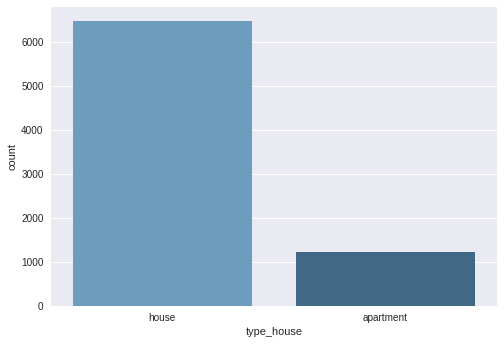

In [10]:
sns.countplot(data=sale_data, x='type_house', palette="Blues_d");

In [11]:
sale_data.drop(columns=['daft_id', 'latitude', 'longitude']).groupby(by='type_house').agg('mean')

,price,floor_area,views,bedroom,bathroom
type_house,,,,,
apartment,320578.248355,76.536184,4813.012336,2.000822,1.615954
house,463748.232598,162.828060,7189.144158,3.686063,2.488038


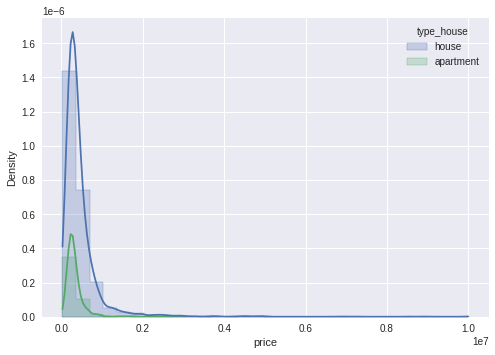

In [12]:
sns.histplot(data=sale_data, x='price', hue='type_house', legend=True, bins=30, 
             kde=True, stat='density', element="step", common_norm=True);

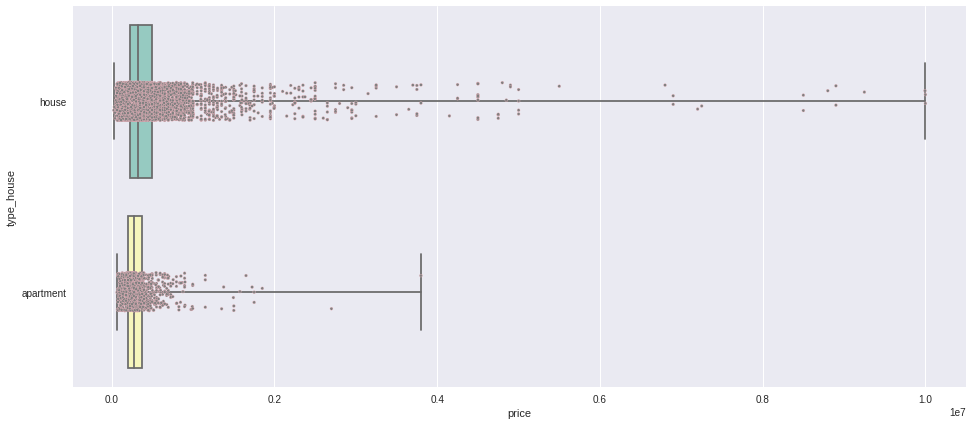

In [13]:
fig, ax = plt.subplots(figsize=(16, 7))

ax = sns.boxplot(data=sale_data, x='price', y='type_house', orient='h', 
                 order=['house', 'apartment'],
                 whis=np.inf, palette="Set3")
ax = sns.stripplot(data=sale_data, x='price', y='type_house' ,orient='h', 
                   order=['house', 'apartment'],
                   color="gray", edgecolor="pink", linewidth=.3,  size=3)

#### Ber

In [29]:
sale.ber.value_counts()

C3        948
C1        839
D1        831
C2        825
D2        719
B3        599
G         573
E1        469
F         424
E2        360
SI_666    302
B2        231
A3        140
A2        121
B1         78
A1          8
Name: ber, dtype: int64

#### Plus Info

In [30]:
sale.plus_info.value_counts()

Detached          2711
Semi-D            1580
Terrace           1145
Apartment         1117
End of Terrace     473
Bungalow           416
Duplex             111
Townhouse          107
House                2
Name: plus_info, dtype: int64

Meter aqui outliers detection para categoricas

### Suposiciones sobre los Datos

Escribir los metodos que se van a utilizar algoritmos tb y que suposiciones tienen sobre los datos.

El hecho del no cumplimiento de la hipotesis la normalidad influye principalmente en las pruebas de hipótesis paramétricos (t-test, anova,…) y en los modelos de regresión.

### Analisis de Normalidad y Homocedasticidad y Heterocedasticidad

### Statistics

- Measures of Position
- Measures of Dispersion
    - MD Absolutes
    - MD Relatives
    - Teorema de Tchebycheff
- Asymmetry and Kurtosis

In [14]:
sale_data.drop(columns=['daft_id']).describe().transpose() # Quiero ver como cambia antes y despues de modif

,count,mean,std,min,25%,50%,75%,max
price,7695.0,441123.840026,559497.409220,25000.000000,220000.000000,315000.000000,475000.000000,1.000000e+07
floor_area,7695.0,149.191813,187.894773,1.000000,83.000000,112.000000,170.000000,1.027900e+04
views,7695.0,6813.656660,7594.513251,0.000000,2526.500000,4567.000000,8257.000000,1.364560e+05
latitude,7695.0,53.073054,0.718554,51.460139,52.607087,53.283705,53.395819,5.536339e+01
longitude,7695.0,-7.432629,1.191594,-10.459878,-8.493948,-7.109124,-6.277835,-6.027847e+00
bedroom,7695.0,3.419753,1.510908,1.000000,3.000000,3.000000,4.000000,4.300000e+01
bathroom,7695.0,2.350227,1.476052,1.000000,1.000000,2.000000,3.000000,4.700000e+01


# Relationships and Feature Selection

In [91]:
sale_data_out.shape

(7387, 34)

In [92]:
sale_data_out.isna().sum()

daft_id                 0
url                     0
name                    0
price                   0
sale_type               0
floor_area              0
entered_renewed         0
views                   0
type_house              0
type                    0
scraping_date           0
latitude                0
longitude               0
bedroom                 0
bathroom                0
country_code            0
country                 0
postcode             1258
state_district        362
county                681
municipality         6140
city                 5432
town                 6277
city_district         365
locality             7382
suburb               5674
road                 1937
house_number         5972
place                1328
code                 1328
admin1               1328
place_coordinates    1328
cities               1328
m2_price                0
dtype: int64

In [93]:
sale_data_out.sample()

,daft_id,url,name,price,sale_type,floor_area,entered_renewed,views,type_house,type,scraping_date,latitude,longitude,bedroom,bathroom,country_code,country,postcode,state_district,county,municipality,city,town,city_district,locality,suburb,road,house_number,place,code,admin1,place_coordinates,cities,m2_price
3060,16239334,https://www.daft.ie/for-sale/semi-detached-hou...,"25 Fairview Avenue Upper, Fairview, Dublin 3",525000.00,For Sale by Private Treaty,84,2021-10-19,6363.00,house,buy,2021-10-19,53.36,-6.24,3,2,ie,Éire / Ireland,D03 YA26,Leinster,County Dublin,NaN,Dublin,NaN,Clontarf West D ED,NaN,Marino,Upper Fairview Avenue,23,Dublin 3,D03,Leinster,53.364/-6.238,Dublin,6250.00


Columnas a tener en cuenta en feature selection:
- price  NUMERIC
- floor_area  NUMERIC
- views  NUMERIC
- type_house  CAREGORICAL
- latitude  NUMERIC
- longitude  NUMERIC
- bedroom  NUMERIC
- bathroom  NUMERIC
- postcode  CAREGORICAL
- state_district
- county  CAREGORICAL
- city_district
- road  CAREGORICAL
- place  CAREGORICAL
- code  CAREGORICAL
- m2_price  NUMERIC

## Scatter Plots

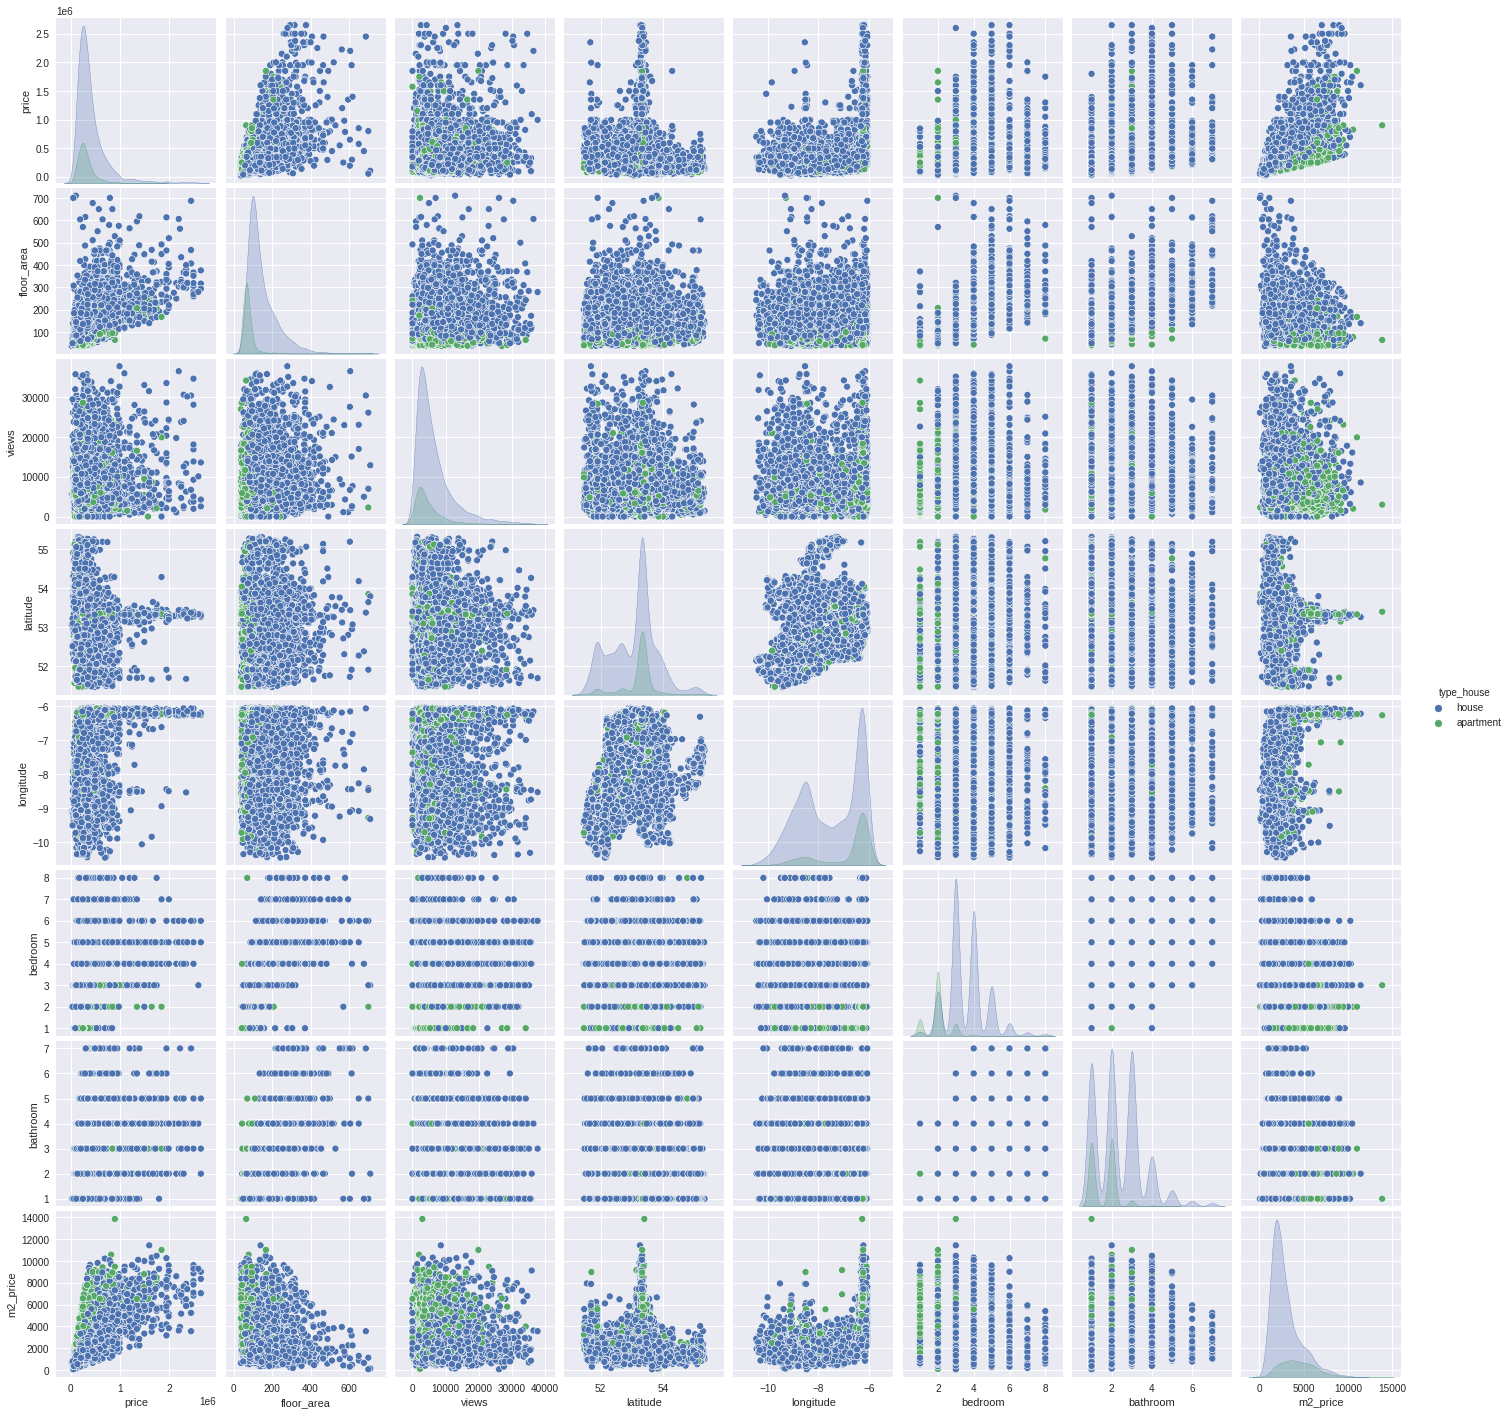

In [94]:
sns.pairplot(sale_data_out.drop(columns=['daft_id']), hue='type_house');

## Correlations

### Pearson's correlation

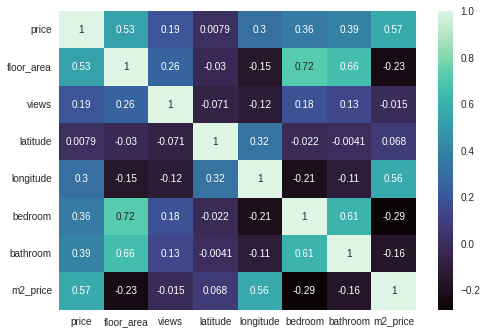

In [95]:
sns.heatmap(sale_data_out.drop(columns=['daft_id']).corr(method='pearson'), annot=True, cmap='mako');  

### Spearman's rank correlation

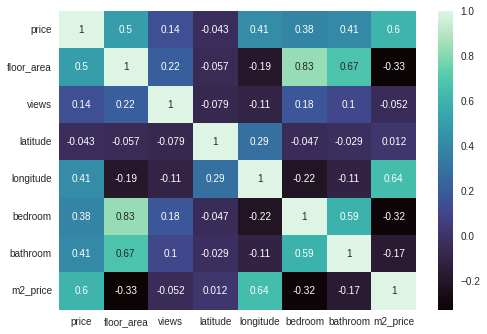

In [96]:
sns.heatmap(sale_data_out.drop(columns=['daft_id']).corr(method='spearman'), annot=True, cmap='mako');  

https://medium.com/towards-data-science/rip-correlation-introducing-the-predictive-power-score-3d90808b9598

## Predictive Power Score

## Wrapper Methods

In [127]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import (RFE, 
                                       SequentialFeatureSelector)

In [128]:
#sale_data_out.isna().sum()

In [129]:
y = sale_data_out['price'].copy()
X = sale_data_out[[#'sale_type',
                   'floor_area',
                   'views',
                   'type_house',
                   'latitude',
                   'longitude',
                   'bedroom',
                   'bathroom',
                   'postcode',
                   'state_district',
                   'county',
                   'city_district',
                   'road',
                   'place',
                   'code',
                   'admin1',
                   #'place_coordinates',
                   'cities']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



((6278, 16), (1109, 16), (6278,), (1109,))

### Recursive Feature Elimination

In [130]:
num_features = ['floor_area',
                'views',
                'latitude',
                'longitude',
                'bedroom',
                'bathroom']
cat_features = [#'sale_type',
                'type_house',
                'postcode',
                'state_district',
                'county',
                'city_district',
                'road',
                'place',
                'code',
                'admin1',
                'cities']

In [131]:
# objeto RFE
# estimador=lr, nuestro modelo
# n_features_to_select=1, numero de features que queremos seleccionar
# step=1, en cada iteracion la RFE quitara una variable
rfe = RFE(estimator=LinearRegression(), 
                            n_features_to_select=1, 
                            step=1)

#model = LinearRegression()

#pipeline = Pipeline(steps=[('s',rfe),('m',model)])

In [132]:
X_train_num = X_train[num_features]
X_test_num = X_test[num_features]

scores_rfe = [] # ahi guardamos los distintos scores que vamos obteniendo
print(X_train_num.columns, '\n')
for i in range(1, X_train_num.shape[1] + 1): # i = 1,..., 1
    
    lr = LinearRegression()
    
    rfe = RFE(estimator=lr, 
              n_features_to_select=i, 
              step=1) # i = 1feature, 2features...
    
    rfe.fit(X_train_num, y_train) # rfe con i features, nos devuelve las i mejores features
    # rfe.fit() selecciona las variables, pero no ajusta el modelo
    
    print(rfe.support_)
    print(rfe.ranking_)
    print(X_train_num.columns[rfe.support_].values, '\n')
    
    lr.fit(X_train_num.loc[:, rfe.support_], y_train) #rfe.support_ para seleccionar las features-columnas
    # estamos entrenando el modelo con las features q nos proporciona el objeto RFE
    scores_rfe.append(lr.score(X_test_num.loc[:, rfe.support_], y_test)) 
    # predecimos sobre el dataset de test con las mismas features que hemos entrenado
    
scores_rfe

Index(['floor_area', 'views', 'latitude', 'longitude', 'bedroom', 'bathroom'], dtype='object') 

[False False False False  True False]
[5 6 4 2 1 3]
['bedroom'] 

[False False False  True  True False]
[4 5 3 1 1 2]
['longitude' 'bedroom'] 

[False False False  True  True  True]
[3 4 2 1 1 1]
['longitude' 'bedroom' 'bathroom'] 

[False False  True  True  True  True]
[2 3 1 1 1 1]
['latitude' 'longitude' 'bedroom' 'bathroom'] 

[ True False  True  True  True  True]
[1 2 1 1 1 1]
['floor_area' 'latitude' 'longitude' 'bedroom' 'bathroom'] 

[ True  True  True  True  True  True]
[1 1 1 1 1 1]
['floor_area' 'views' 'latitude' 'longitude' 'bedroom' 'bathroom'] 



[0.14325902693605141,
 0.2904902738431079,
 0.3251087968382107,
 0.34080610654572463,
 0.4356621473231068,
 0.43990828298274565]

Podriamos coger las 5 primeras variables

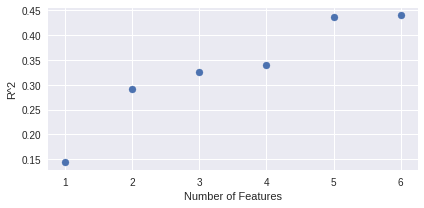

In [133]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train_num.shape[1] + 1), scores_rfe) # x=1a13, y=scores

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
plt.tight_layout()

### Forward Feature Selection

In [134]:
X_train_num.columns

Index(['floor_area', 'views', 'latitude', 'longitude', 'bedroom', 'bathroom'], dtype='object')

In [135]:
scores_sfs_forward = [] # ahi guardamos los distintos scores que vamos obteniendo
#print(X_train_num.columns)
for i in range(1, X_train_num.shape[1]): # i = 1,..., 12
    # este no quiere que le selecciones tantas features como tenga el dataset, quiere menos
    lr = LinearRegression()
    sfs = SequentialFeatureSelector(estimator=lr, 
                                    n_features_to_select=i, 
                                    direction='forward') 
    sfs.fit(X_train_num, y_train)    
    
    #print(sfs.support_)
    #print(sfs.ranking_)
    print(X_train_num.columns[sfs.support_].values, '\n')
    
    lr.fit(X_train_num.loc[:, sfs.support_], y_train)
    
    scores_sfs_forward.append(lr.score(X_test_num.loc[:, sfs.support_], 
                               y_test)) 
    
scores_sfs_forward

['floor_area'] 

['floor_area' 'longitude'] 

['floor_area' 'latitude' 'longitude'] 

['floor_area' 'views' 'latitude' 'longitude'] 

['floor_area' 'views' 'latitude' 'longitude' 'bathroom'] 



[0.26370499299690353,
 0.4149270162764338,
 0.42886472531810416,
 0.43235157528900514,
 0.4391624854908267]

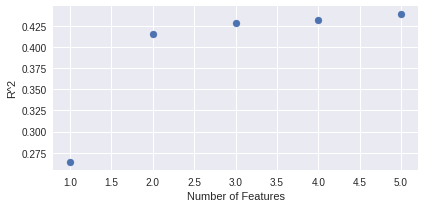

In [136]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train_num.shape[1]), scores_sfs_forward) # x=1a12, y=scores

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
plt.tight_layout()

### Backward Feature Elimination

In [137]:
print(X_train_num.columns.values)

['floor_area' 'views' 'latitude' 'longitude' 'bedroom' 'bathroom']


In [138]:
from sklearn.tree import DecisionTreeRegressor

scores_sfs_backward = [] # ahi guardamos los distintos scores que vamos obteniendo
#print(X_train_num.columns)
for i in range(1, X_train_num.shape[1]): # i = 1,..., 12
    # este no quiere que le selecciones tantas features como tenga el dataset, quiere menos
    lr = LinearRegression()
    dt = DecisionTreeRegressor()
    
    sfs = SequentialFeatureSelector(estimator=dt,  #lr, 
                                    n_features_to_select=i, 
                                    direction='backward',
                                   ) 
    sfs.fit(X_train_num, y_train)    
    
    #print(sfs.support_)
    #print(sfs.ranking_)
    print(X_train_num.columns[sfs.support_].values, '\n')
    
    #lr.fit(X_train_num.loc[:, sfs.support_], y_train)
    dt.fit(X_train_num.loc[:, sfs.support_], y_train)
    
    #scores_sfs_backward.append(lr.score(X_test_num.loc[:, sfs.support_], 
     #                          y_test)) 
    scores_sfs_backward.append(dt.score(X_test_num.loc[:, sfs.support_], 
                               y_test)) 
    
scores_sfs_backward

['floor_area'] 

['floor_area' 'longitude'] 

['floor_area' 'latitude' 'longitude'] 

['floor_area' 'latitude' 'longitude' 'bedroom'] 

['floor_area' 'latitude' 'longitude' 'bedroom' 'bathroom'] 



[0.19736713677083895,
 0.44433026878209736,
 0.6325825819920131,
 0.6287893955096867,
 0.6485527331565923]

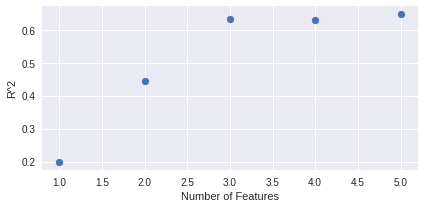

In [139]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train_num.shape[1]), scores_sfs_backward) # x=1a12, y=scores

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
plt.tight_layout()

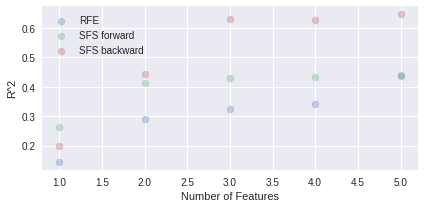

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(range(1, X_train_num.shape[1]), scores_rfe[:-1], label='RFE', alpha=.3) # le quitamos la ultima muestra
ax.scatter(range(1, X_train_num.shape[1]), scores_sfs_forward, label='SFS forward', alpha=.3)
ax.scatter(range(1, X_train_num.shape[1]), scores_sfs_backward, label='SFS backward', alpha=.3)

ax.set_xlabel('Number of Features')
ax.set_ylabel('R^2')
ax.legend()
plt.tight_layout()

### Exhaustive Feature Selection

## *SelectKBest* Feature Selection Strategy

### F Value in Regression

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [98]:
num_features = ['floor_area',
                'views','latitude',
                'longitude',
                'bedroom',
                'bathroom']
cat_features = ['type_house',
                'postcode',
                'state_district',
                'city_district',
                'county',
                'road',
                'place',
                'code']

def split_data(data, num_features, target='price'):

    y = data[target].copy()
    X = data[num_features].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [99]:
y = sale_data_out['price'].copy()
X = sale_data_out[['floor_area',
                'views','latitude',
                'longitude',
                'bedroom',
                'bathroom']].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6278, 6), (1109, 6), (6278,), (1109,))

In [100]:
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

In [101]:
X_train_fs, X_test_fs, fs = select_features(X_train=X_train, y_train=y_train, X_test=X_test)

In [102]:
fs.scores_

array([2.46501496e+03, 2.45769570e+02, 5.09378743e-01, 6.48063564e+02,
       9.12540858e+02, 1.13020712e+03])

In [103]:
for i, feature in zip(range(len(fs.scores_)), fs.get_feature_names_out()):
	print('%s: %f' % (feature, fs.scores_[i]))

floor_area: 2465.014963
views: 245.769570
latitude: 0.509379
longitude: 648.063564
bedroom: 912.540858
bathroom: 1130.207118


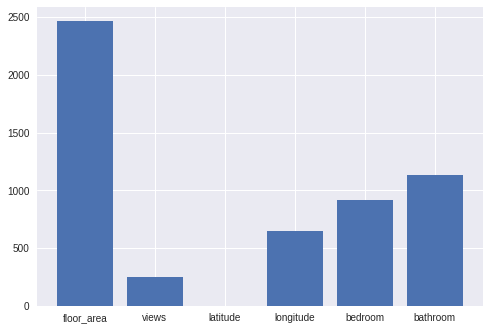

In [104]:
plt.bar(fs.get_feature_names_out(), fs.scores_);

In [105]:
f_regression(X_train, y_train)[0] # F score
f_regression(X_train, y_train)[1] # p-values

array([0.00000000e+000, 2.30950252e-054, 4.75434457e-001, 3.91627028e-136,
       2.76179432e-187, 5.59989132e-228])

In [106]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_regression at 0x7f9c764f4e60>)

In [107]:
fs.scores_

array([2.46501496e+03, 2.45769570e+02, 5.09378743e-01, 6.48063564e+02,
       9.12540858e+02, 1.13020712e+03])

In [108]:
for p in fs.pvalues_:
    print(round(p, 6))

0.0
0.0
0.475434
0.0
0.0
0.0


### Mutual Information

In [109]:
from sklearn.feature_selection import mutual_info_regression

In [110]:
def select_features(X_train, y_train, X_test, score_func):
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

In [111]:
X_train_fs, X_test_fs, fs = select_features(X_train=X_train, y_train=y_train, X_test=X_test, 
                                            score_func=mutual_info_regression)

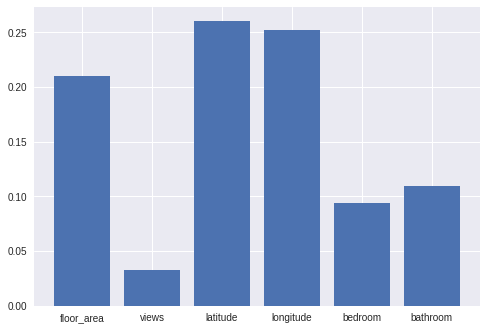

In [112]:
plt.bar(fs.get_feature_names_out(), fs.scores_);

In [113]:
fs.scores_

array([0.20972369, 0.03289261, 0.26014718, 0.25187282, 0.09434222,
       0.1096913 ])

## ANOVA

Let's study first the variables `place` and `price`.

- `place`: Categorical variable with more than three groups (138 groups) -> One-way ANOVA
- `price`: Numerical variaable

The hipothess will be:

* Null Hypothesis, H0: There is no significant difference between the mean `price` among different groups of `place`.
* Alternate Hypothesis, H1: There is a significant difference between the mean `price` among different groups of `place`.

In [114]:
sale_data_out.isna().sum()

daft_id                 0
url                     0
name                    0
price                   0
sale_type               0
floor_area              0
entered_renewed         0
views                   0
type_house              0
type                    0
scraping_date           0
latitude                0
longitude               0
bedroom                 0
bathroom                0
country_code            0
country                 0
postcode             1258
state_district        362
county                681
municipality         6140
city                 5432
town                 6277
city_district         365
locality             7382
suburb               5674
road                 1937
house_number         5972
place                1328
code                 1328
admin1               1328
place_coordinates    1328
cities               1328
m2_price                0
dtype: int64

In [115]:
from sklearn.feature_selection import f_classif

In [116]:
sale_data_out[['type_house',
                'postcode',
                'state_district',
                'city_district',
                'county',
                'road',
                'place',
                'code']].isna().sum()

type_house           0
postcode          1258
state_district     362
city_district      365
county             681
road              1937
place             1328
code              1328
dtype: int64

In [117]:
cat_features = ['type_house',
                'postcode',
                'state_district',
                'city_district',
                'county',
                'road',
                'place',
                'code']

def split_data_cat(data, cat_features, target='price'):

    y = data[target].copy()
    X = data[cat_features].copy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=42)
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return X_train, X_test, y_train, y_test

In [118]:
X_train, X_test, y_train, y_test = split_data_cat(data=sale_data_out, 
                      cat_features=['type_house',
                                    'postcode',
                                    'state_district',
                                    'city_district',
                                    'county',
                                    'road',
                                    'place',
                                    'code'], 
                      target='price')

(6278, 8) (1109, 8) (6278,) (1109,)


In [119]:
X_train.columns

Index(['type_house', 'postcode', 'state_district', 'city_district', 'county',
       'road', 'place', 'code'],
      dtype='object')

In [120]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X_train.type_house)
le.classes_

array(['apartment', 'house'], dtype=object)

In [121]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
cols = ['type_house',
        'postcode',
        'state_district',
        'city_district',
        'county',
        'road',
        'place',
        'code']


for column in cols:
    X_train[column] = le.fit_transform(X_train[column])

In [122]:
X_train[cols].columns

Index(['type_house', 'postcode', 'state_district', 'city_district', 'county',
       'road', 'place', 'code'],
      dtype='object')

In [123]:
X_train[cols].head()

,type_house,postcode,state_district,city_district,county,road,place,code
1877,1,1677,1,1604,29,3323,137,137
5373,0,490,1,904,29,1337,51,29
5230,1,719,0,395,17,1246,31,48
102,1,1666,1,1706,27,349,134,136
4363,1,1211,1,1375,12,3323,115,103


In [124]:
f_classif(X_train[['type_house']], y_train)

(array([1.16260403]), array([0.01124766]))

In [125]:
for feature in cols:
    f_value, p_value = f_classif(X_train[[feature]], y_train)
    print(f'{feature}: f_value = {round(f_value[0], 4)}, p_value = {round(p_value[0], 4)}')

type_house: f_value = 1.1626, p_value = 0.0112
postcode: f_value = 3.0085, p_value = 0.0
state_district: f_value = 1.1139, p_value = 0.0516
city_district: f_value = 1.0076, p_value = 0.4482
county: f_value = 1.202, p_value = 0.0026
road: f_value = 1.2815, p_value = 0.0001
place: f_value = 1.7202, p_value = 0.0
code: f_value = 2.8821, p_value = 0.0


In [126]:
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs